# Sistem Rekomendasi Buku dengan menggunakan Metode Collaborative Filtering

## Pendahuluan

### Latar Belakang

Di era yang semakin berkembang ini banyak bidang bisnis yang menggunakan machine learning untuk meningkatkan produktifitas mereka. Misalnya dengan menggunakan sistem rekomendasi mereka akan mendapatkan banyak keuntungan dari pembelian barang yang direkomendasikan atau bahkan meningkatkan pengunjung toko. Hal ini juga dapat diterapkan pada toko buku atau perpustakaan agar pengunjung mendapatkan rekomendasi buku yang tepat. Sistem rekomendasi buku juga berperan untuk meningkatkan literasi pada masyarakat yang saat ini masih rendah.

Maka dari itu, di sini saya mengangkat judul Pembuatan Sistem Rekomendasi Buku dengan menggunakan Metode Collaborative Filtering

## Penyiapan Data

### Import Library

In [1]:
!pip install optuna

     |████████████████████████████████| 308 kB 12.9 MB/s 
     |████████████████████████████████| 209 kB 50.1 MB/s 
     |████████████████████████████████| 80 kB 9.3 MB/s 
     |████████████████████████████████| 75 kB 4.6 MB/s 
     |████████████████████████████████| 112 kB 57.1 MB/s 
     |████████████████████████████████| 148 kB 50.6 MB/s 
     |████████████████████████████████| 49 kB 6.1 MB/s 
  Created wheel for pyperclip: filename=pyperclip-1.8.2-py3-none-any.whl size=11136 sha256=ba9ca159afdc01d99f19aca127473eb64dfae091a25325d1aa58cd531fbf0b35
  Stored in directory: /root/.cache/pip/wheels/9f/18/84/8f69f8b08169c7bae2dde6bd7daf0c19fca8c8e500ee620a28
Successfully built pyperclip


In [2]:
from google.colab import files
import os
import zipfile
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
import optuna

### Menyiapkan Kredensial Kaggle

Dataset yang akan dipakai dalam proyek ini diambil dari platform Kaggle. Maka dari itu, sebelum dapat mengunduh data, harus mengunggah kredensial berupa file JSON yang dapat di-generate melalui profil akun Kaggle. 

In [3]:
# Upload kaggle.json

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}"'.format(
      name=fn))

Saving kaggle.json to kaggle.json
User uploaded file "kaggle.json"


In [4]:
# Ubah permission file
!chmod 600 /content/kaggle.json

In [5]:
# Setup Kaggle environment
os.environ['KAGGLE_CONFIG_DIR'] = "/content"

### Mengunduh Dataset

![Book Recommendation Dataset](https://i.postimg.cc/0Q4fcMDB/rsz-bookrecommendationdataset.jpg)

Informasi Dataset:

Jenis | Keterangan
--- | ---
Title | Book Recommendation Dataset
Source | [Kaggle](https://www.kaggle.com/arashnic/book-recommendation-dataset)
Maintainer | [Möbius](https://www.kaggle.com/arashnic)
License | [CC0: Public Domain](https://creativecommons.org/publicdomain/zero/1.0/)
Usability | 10.0

In [6]:
# Download Dataset
!kaggle datasets download -d arashnic/book-recommendation-dataset

 38% 9.00M/23.8M [00:00<00:01, 9.53MB/s]
100% 23.8M/23.8M [00:00<00:00, 25.8MB/s]


In [7]:
# melakukan ekstraksi pada file zip
local_zip = 'book-recommendation-dataset.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/content/book-recommendation-dataset/')
zip_ref.close()

In [8]:
# Menghapus berkas zip yang sudah tidak diperlukan
!rm book-recommendation-dataset.zip

## Data Understanding

Pada Dataset ini terdapat 3 berkas csv diantaranya yaitu Books.csv , Ratings.csv , dan Users.csv

Selanjutnya kita akan buka dengan bantuan `pandas` untuk melihat isi dari masing-masing berkas csv tersebut.

In [9]:
# Load dataset

books = pd.read_csv('book-recommendation-dataset/Books.csv')
ratings = pd.read_csv('book-recommendation-dataset/Ratings.csv')
users = pd.read_csv('book-recommendation-dataset/Users.csv')

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning:

Columns (3) have mixed types.Specify dtype option on import or set low_memory=False.



### Books

Berikut ini adalah isi dari `Books.csv`

In [ ]:
books

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...
2,0060973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...
3,0374157065,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata,1999,Farrar Straus Giroux,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...
4,0393045218,The Mummies of Urumchi,E. J. W. Barber,1999,W. W. Norton &amp; Company,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...
...,...,...,...,...,...,...,...,...
271355,0440400988,There's a Bat in Bunk Five,Paula Danziger,1988,Random House Childrens Pub (Mm),http://images.amazon.com/images/P/0440400988.0...,http://images.amazon.com/images/P/0440400988.0...,http://images.amazon.com/images/P/0440400988.0...
271356,0525447644,From One to One Hundred,Teri Sloat,1991,Dutton Books,http://images.amazon.com/images/P/0525447644.0...,http://images.amazon.com/images/P/0525447644.0...,http://images.amazon.com/images/P/0525447644.0...
271357,006008667X,Lily Dale : The True Story of the Town that Ta...,Christine Wicker,2004,HarperSanFrancisco,http://images.amazon.com/images/P/006008667X.0...,http://images.amazon.com/images/P/006008667X.0...,http://images.amazon.com/images/P/006008667X.0...
271358,0192126040,Republic (World's Classics),Plato,1996,Oxford University Press,http://images.amazon.com/images/P/0192126040.0...,http://images.amazon.com/images/P/0192126040.0...,http://images.amazon.com/images/P/0192126040.0...


In [ ]:
books.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 271360 entries, 0 to 271359
Data columns (total 8 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   ISBN                 271360 non-null  object
 1   Book-Title           271360 non-null  object
 2   Book-Author          271359 non-null  object
 3   Year-Of-Publication  271360 non-null  object
 4   Publisher            271358 non-null  object
 5   Image-URL-S          271360 non-null  object
 6   Image-URL-M          271360 non-null  object
 7   Image-URL-L          271357 non-null  object
dtypes: object(8)
memory usage: 16.6+ MB


Dari keluaran di atas dapat diketahui bahwa berkas `Books.csv` memuat data-data buku yang terdiri dari 271360 baris dan memiliki 8 kolom, diantaranya adalah :  

- `ISBN` : berisi kode ISBN dari buku  
- `Book-Title` : berisi judul buku
- `Book-Author` : berisi penulis buku
- `Year-Of-Publication` : tahun terbit buku  
- `Publisher` : penerbit buku  
- `Image-URL-S` : URL menuju gambar buku berukuran kecil
- `Image-URL-M` : URL menuju gambar buku berukuran sedang
- `Image-URL-L` : URL menuju gambar buku berukuran besar

### Ratings

Berikut ini adalah isi dari berkas `Ratings.csv`

In [ ]:
ratings

,User-ID,ISBN,Book-Rating
0,276725,034545104X,0
1,276726,0155061224,5
2,276727,0446520802,0
3,276729,052165615X,3
4,276729,0521795028,6
...,...,...,...
1149775,276704,1563526298,9
1149776,276706,0679447156,0
1149777,276709,0515107662,10
1149778,276721,0590442449,10


In [10]:
ratings.groupby('Book-Rating').count()

,User-ID,ISBN
Book-Rating,,
0,716109,716109
1,1770,1770
2,2759,2759
3,5996,5996
4,8904,8904
5,50974,50974
6,36924,36924
7,76457,76457
8,103736,103736


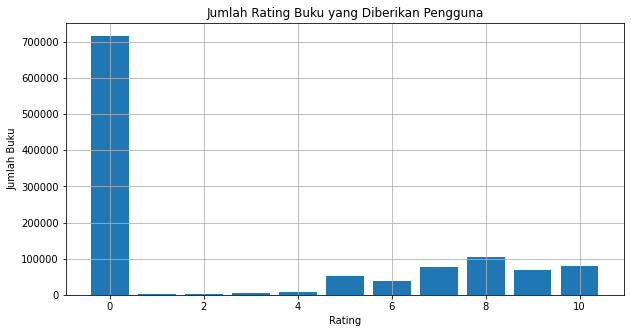

In [11]:
rating_counter = ratings.groupby('Book-Rating').count()
plt.figure(figsize=(10,5))
plt.title('Jumlah Rating Buku yang Diberikan Pengguna')
plt.xlabel('Rating')
plt.ylabel('Jumlah Buku')
plt.bar(rating_counter.index, rating_counter['ISBN'])
plt.grid(True)
plt.show()

Pada visualisasi data di atas dapat diketahui bahwa data tidak seimbang dan banyak pengguna yang memberikan rating 0. 

In [12]:
ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1149780 entries, 0 to 1149779
Data columns (total 3 columns):
 #   Column       Non-Null Count    Dtype 
---  ------       --------------    ----- 
 0   User-ID      1149780 non-null  int64 
 1   ISBN         1149780 non-null  object
 2   Book-Rating  1149780 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 26.3+ MB


In [13]:
ratings.describe().apply(lambda s: s.apply(lambda x: format(x, 'f')))

,User-ID,Book-Rating
count,1149780.000000,1149780.000000
mean,140386.395126,2.866950
std,80562.277718,3.854184
min,2.000000,0.000000
25%,70345.000000,0.000000
50%,141010.000000,0.000000
75%,211028.000000,7.000000
max,278854.000000,10.000000


Dari keluaran di atas dapat diketahui bahwa berkas `Ratings.csv` memuat data rating buku yang diberikan oleh pengguna. Data ini memiliki 1149780 baris dan memiliki 3 kolom, yaitu :  
 - `User-ID` : berisi ID unik pengguna
 - `ISBN` : berisi kode ISBN buku yang diberi rating oleh pengguna
 - `Book-Rating` : berisi nilai rating yang diberikan oleh pengguna berkisar antara 0-10

### Users

Berikut ini adalah isi dari `Users.csv`

In [ ]:
users

,User-ID,Location,Age
0,1,"nyc, new york, usa",NaN
1,2,"stockton, california, usa",18.0
2,3,"moscow, yukon territory, russia",NaN
3,4,"porto, v.n.gaia, portugal",17.0
4,5,"farnborough, hants, united kingdom",NaN
...,...,...,...
278853,278854,"portland, oregon, usa",NaN
278854,278855,"tacoma, washington, united kingdom",50.0
278855,278856,"brampton, ontario, canada",NaN
278856,278857,"knoxville, tennessee, usa",NaN


In [ ]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 278858 entries, 0 to 278857
Data columns (total 3 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   User-ID   278858 non-null  int64  
 1   Location  278858 non-null  object 
 2   Age       168096 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 6.4+ MB


In [ ]:
users.describe()

,User-ID,Age
count,278858.00000,168096.000000
mean,139429.50000,34.751434
std,80499.51502,14.428097
min,1.00000,0.000000
25%,69715.25000,24.000000
50%,139429.50000,32.000000
75%,209143.75000,44.000000
max,278858.00000,244.000000


Dari keluaran di atas dapat diketahui bahwa berkas `Users.csv` memuat data pengguna. Data ini terdiri dari 278858 baris dan memiliki 3 kolom, yaitu : 

- `User-ID` : berisi ID unik pengguna
- `Location` : berisi data lokasi pengguna
- `Age` : berisi data usia pengguna

## Data Preparation

Sebelum dapat dilakukan pemodelan, maka data harus melalui tahap data preparation terlebih dahulu. Berikut adalah langkah-langkah yang dilakukan dalam data preparation.

### Handling Imbalanced Data

Sebelumnya telah diketahui bahwa data rating tidak seimbang, untuk itu pada tahap ini saya mencoba untuk menghapus data rating 0.

In [19]:
ratings.drop(ratings[ratings["Book-Rating"] == 0].index, inplace=True)

Berikut ini adalah jumlah data setelah di-drop

In [21]:
ratings.shape

(433671, 3)

In [22]:
ratings

,User-ID,ISBN,Book-Rating
1,276726,0155061224,5
3,276729,052165615X,3
4,276729,0521795028,6
6,276736,3257224281,8
7,276737,0600570967,6
...,...,...,...
1149773,276704,0806917695,5
1149775,276704,1563526298,9
1149777,276709,0515107662,10
1149778,276721,0590442449,10


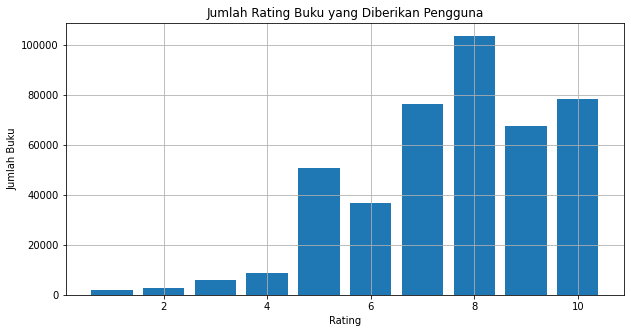

In [23]:
rating_counter = ratings.groupby('Book-Rating').count()
plt.figure(figsize=(10,5))
plt.title('Jumlah Rating Buku yang Diberikan Pengguna')
plt.xlabel('Rating')
plt.ylabel('Jumlah Buku')
plt.bar(rating_counter.index, rating_counter['ISBN'])
plt.grid(True)
plt.show()

### Encoding Data

Encoding dilakukan untuk menyandikan `User-ID` dan `ISBN` ke dalam indeks integer

In [24]:
# Mengubah userID menjadi list tanpa nilai yang sama
user_ids = ratings['User-ID'].unique().tolist()
 
# Melakukan encoding userID
user_to_user_encoded = {x: i for i, x in enumerate(user_ids)}
 
# Melakukan proses encoding angka ke ke userID
user_encoded_to_user = {i: x for i, x in enumerate(user_ids)}

In [25]:
# Mengubah ISBN menjadi list tanpa nilai yang sama
isbn_list = ratings['ISBN'].unique().tolist()
 
# Melakukan encoding ISBN
isbn_to_isbn_encoded = {x: i for i, x in enumerate(isbn_list)}
 
# Melakukan proses encoding angka ke ISBN
isbn_encoded_to_isbn = {i: x for i, x in enumerate(isbn_list)}

Setelah itu hasil dari encoding akan dimapping ke dataframe `ratings`

In [26]:
# Mapping userID ke dataframe user
ratings['user'] = ratings['User-ID'].map(user_to_user_encoded)

In [27]:
# Mapping userID ke dataframe user
ratings['book'] = ratings['ISBN'].map(isbn_to_isbn_encoded)

In [28]:
ratings

,User-ID,ISBN,Book-Rating,user,book
1,276726,0155061224,5,0,0
3,276729,052165615X,3,1,1
4,276729,0521795028,6,1,2
6,276736,3257224281,8,2,3
7,276737,0600570967,6,3,4
...,...,...,...,...,...
1149773,276704,0806917695,5,77801,185971
1149775,276704,1563526298,9,77801,121200
1149777,276709,0515107662,10,77802,23986
1149778,276721,0590442449,10,77803,151038


In [29]:
ratings.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 433671 entries, 1 to 1149779
Data columns (total 5 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   User-ID      433671 non-null  int64 
 1   ISBN         433671 non-null  object
 2   Book-Rating  433671 non-null  int64 
 3   user         433671 non-null  int64 
 4   book         433671 non-null  int64 
dtypes: int64(4), object(1)
memory usage: 19.9+ MB


### Randomize Dataset

Berikut ini adalah proses pengacakan data agar distribusi datanya menjadi random.

In [30]:
# Mengacak dataset
df = ratings.sample(frac=1, random_state=42)
df

,User-ID,ISBN,Book-Rating,user,book
144846,32440,0380018179,8,9713,1013
211411,49144,8422641127,5,14390,54663
647520,156424,3442453844,7,44370,127953
30124,7125,0060586125,8,2587,10359
1052982,251606,0316789844,8,70897,7053
...,...,...,...,...,...
658592,159834,0441132456,7,45235,70428
958724,231613,0747542333,5,65186,33018
335707,79923,0440206154,8,22993,6822
373697,89610,8880891960,5,25753,84887


### Data Standardization and Splitting

Setelah datanya diacak, kemudian dataset dibagi menjadi 2 bagian, yaitu data yang akan digunakan untuk melatih model (sebesar 80%) dan data untuk memvalidasi model (sebesar 20%).

Selain itu juga dilakukan standarisasi nilai rating yang sebelumnya berada di rentang 0 hingga 10 kini diubah ke rentang 0 hingga 1 untuk mempermudah dalam proses training

In [31]:
# Mendapatkan jumlah user
num_users = len(user_to_user_encoded)
print(num_users)
 
# Mendapatkan jumlah resto
num_isbn = len(isbn_encoded_to_isbn)
print(num_isbn)
 
# Mengubah rating menjadi nilai float
df['Book-Rating'] = df['Book-Rating'].values.astype(np.float32)
 
# Nilai minimum Book-Rating
min_rating = min(df['Book-Rating'])
 
# Nilai maksimal Book-Rating
max_rating = max(df['Book-Rating'])
 
print('Number of User: {}, Number of ISBN: {}, Min Rating: {}, Max Rating: {}'.format(
    num_users, num_isbn, min_rating, max_rating
))

77805
185973
Number of User: 77805, Number of ISBN: 185973, Min Rating: 1.0, Max Rating: 10.0


In [32]:
# Membuat variabel x untuk mencocokkan data user dan book menjadi satu value
x = df[['user', 'book']].values
 
# Membuat variabel y untuk membuat rating dari hasil 
y = df['Book-Rating'].apply(lambda x: (x - min_rating) / (max_rating - min_rating)).values
 
# Membagi menjadi 80% data train dan 20% data validasi
train_indices = int(0.8 * df.shape[0])
x_train, x_val, y_train, y_val = (
    x[:train_indices],
    x[train_indices:],
    y[:train_indices],
    y[train_indices:]
)
 
print(x, y)

[[  9713   1013]
 [ 14390  54663]
 [ 44370 127953]
 ...
 [ 22993   6822]
 [ 25753  84887]
 [ 21414  43793]] [0.77777778 0.44444444 0.66666667 ... 0.77777778 0.44444444 0.77777778]


## Modelling

### Membuat Kelas RecommenderNet

In [33]:
class RecommenderNet(tf.keras.Model):
 
  # Insialisasi fungsi
  def __init__(self, num_users, num_isbn, embedding_size, **kwargs):
    super(RecommenderNet, self).__init__(**kwargs)
    self.num_users = num_users
    self.num_isbn = num_isbn
    self.embedding_size = embedding_size
    self.user_embedding = layers.Embedding( # layer embedding user
        num_users,
        embedding_size,
        embeddings_initializer = 'he_normal',
        embeddings_regularizer = keras.regularizers.l2(1e-6)
    )
    self.user_bias = layers.Embedding(num_users, 1) # layer embedding user bias
    self.book_embedding = layers.Embedding( # layer embeddings book
        num_isbn,
        embedding_size,
        embeddings_initializer = 'he_normal',
        embeddings_regularizer = keras.regularizers.l2(1e-6)
    )
    self.book_bias = layers.Embedding(num_isbn, 1) # layer embedding book bias
 
  def call(self, inputs):
    user_vector = self.user_embedding(inputs[:,0]) # memanggil layer embedding 1
    user_bias = self.user_bias(inputs[:, 0]) # memanggil layer embedding 2
    book_vector = self.book_embedding(inputs[:, 1]) # memanggil layer embedding 3
    book_bias = self.book_bias(inputs[:, 1]) # memanggil layer embedding 4
 
    dot_user_book = tf.tensordot(user_vector, book_vector, 2) 
 
    x = dot_user_book + user_bias + book_bias
    
    return tf.nn.sigmoid(x) # activation sigmoid

### Hyperparameter Tuning

Agar mendapatkan hasil model yang optimal, maka dalam proyek ini menggunakan bantuan library `optuna` untuk melakukan hyperparameter tuning atau pencarian nilai hyperparameter yang terbaik, dalam hal ini adalah nilai `embedding_size`.

In [54]:
def objective(trial):
    tf.keras.backend.clear_session()
    model = RecommenderNet(num_users=num_users, num_isbn=num_isbn, embedding_size=trial.suggest_int('embedding_size', 1, 15))

    # model compile
    model.compile(
        loss = tf.keras.losses.BinaryCrossentropy(),
        optimizer = keras.optimizers.Adam(learning_rate=0.001),
        metrics=[tf.keras.metrics.RootMeanSquaredError()]
    )

    model.fit(
        x = x_train,
        y = y_train,
        batch_size=200,
        epochs = 1,
        validation_data = (x_val, y_val)
    )
    
    y_pred= model.predict(x_val)

    return mean_squared_error(y_val, y_pred, squared=False)

study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=15, timeout=500)

print("Number of finished trials: {}".format(len(study.trials)))

print("Best trial:")
trial = study.best_trial

print("  Value: {}".format(trial.value))

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

[I 2021-11-18 06:37:14,293] A new study created in memory with name: no-name-232ad717-5ef8-4957-8a07-48a3762d8bc5


1735/1735 [==============================] - 18s 10ms/step - loss: 0.6235 - root_mean_squared_error: 0.2502 - val_loss: 0.5740 - val_root_mean_squared_error: 0.1975


[I 2021-11-18 06:37:46,117] Trial 0 finished with value: 0.2557546591392969 and parameters: {'embedding_size': 14}. Best is trial 0 with value: 0.2557546591392969.


1735/1735 [==============================] - 18s 10ms/step - loss: 0.6239 - root_mean_squared_error: 0.2506 - val_loss: 0.5740 - val_root_mean_squared_error: 0.1975


[I 2021-11-18 06:38:17,930] Trial 1 finished with value: 0.2556821394318727 and parameters: {'embedding_size': 13}. Best is trial 1 with value: 0.2556821394318727.


1735/1735 [==============================] - 18s 10ms/step - loss: 0.6254 - root_mean_squared_error: 0.2520 - val_loss: 0.5741 - val_root_mean_squared_error: 0.1975


[I 2021-11-18 06:38:45,493] Trial 2 finished with value: 0.25515487871445475 and parameters: {'embedding_size': 14}. Best is trial 2 with value: 0.25515487871445475.


1735/1735 [==============================] - 15s 8ms/step - loss: 0.6221 - root_mean_squared_error: 0.2491 - val_loss: 0.5735 - val_root_mean_squared_error: 0.1974


[I 2021-11-18 06:39:13,058] Trial 3 finished with value: 0.25653338962612343 and parameters: {'embedding_size': 10}. Best is trial 2 with value: 0.25515487871445475.


1735/1735 [==============================] - 18s 10ms/step - loss: 0.6232 - root_mean_squared_error: 0.2499 - val_loss: 0.5739 - val_root_mean_squared_error: 0.1974


[I 2021-11-18 06:39:36,920] Trial 4 finished with value: 0.25564536949808375 and parameters: {'embedding_size': 14}. Best is trial 2 with value: 0.25515487871445475.


1735/1735 [==============================] - 14s 7ms/step - loss: 0.6341 - root_mean_squared_error: 0.2603 - val_loss: 0.5739 - val_root_mean_squared_error: 0.1981


[I 2021-11-18 06:40:04,056] Trial 5 finished with value: 0.2529098444627046 and parameters: {'embedding_size': 6}. Best is trial 5 with value: 0.2529098444627046.


1735/1735 [==============================] - 12s 6ms/step - loss: 0.6294 - root_mean_squared_error: 0.2561 - val_loss: 0.5729 - val_root_mean_squared_error: 0.1976


[I 2021-11-18 06:40:35,870] Trial 6 finished with value: 0.25295792775782605 and parameters: {'embedding_size': 2}. Best is trial 5 with value: 0.2529098444627046.


1735/1735 [==============================] - 12s 6ms/step - loss: 0.6308 - root_mean_squared_error: 0.2574 - val_loss: 0.5728 - val_root_mean_squared_error: 0.1975


[I 2021-11-18 06:41:03,218] Trial 7 finished with value: 0.2531129521235431 and parameters: {'embedding_size': 2}. Best is trial 5 with value: 0.2529098444627046.


1735/1735 [==============================] - 18s 10ms/step - loss: 0.6219 - root_mean_squared_error: 0.2486 - val_loss: 0.5741 - val_root_mean_squared_error: 0.1975


[I 2021-11-18 06:41:27,708] Trial 8 finished with value: 0.25665351093728445 and parameters: {'embedding_size': 15}. Best is trial 5 with value: 0.2529098444627046.


1735/1735 [==============================] - 12s 6ms/step - loss: 0.6372 - root_mean_squared_error: 0.2631 - val_loss: 0.5735 - val_root_mean_squared_error: 0.1983


[I 2021-11-18 06:41:45,721] Trial 9 finished with value: 0.2517948520852919 and parameters: {'embedding_size': 1}. Best is trial 9 with value: 0.2517948520852919.


1735/1735 [==============================] - 13s 7ms/step - loss: 0.6260 - root_mean_squared_error: 0.2529 - val_loss: 0.5733 - val_root_mean_squared_error: 0.1976


[I 2021-11-18 06:42:12,856] Trial 10 finished with value: 0.2548139893316496 and parameters: {'embedding_size': 6}. Best is trial 9 with value: 0.2517948520852919.


1735/1735 [==============================] - 13s 7ms/step - loss: 0.6239 - root_mean_squared_error: 0.2510 - val_loss: 0.5730 - val_root_mean_squared_error: 0.1974


[I 2021-11-18 06:42:39,951] Trial 11 finished with value: 0.25576031528582255 and parameters: {'embedding_size': 5}. Best is trial 9 with value: 0.2517948520852919.


1735/1735 [==============================] - 14s 8ms/step - loss: 0.6307 - root_mean_squared_error: 0.2572 - val_loss: 0.5732 - val_root_mean_squared_error: 0.1976


[I 2021-11-18 06:43:00,439] Trial 12 finished with value: 0.25393488087196747 and parameters: {'embedding_size': 5}. Best is trial 9 with value: 0.2517948520852919.


1735/1735 [==============================] - 13s 7ms/step - loss: 0.6513 - root_mean_squared_error: 0.2755 - val_loss: 0.5882 - val_root_mean_squared_error: 0.2136


[I 2021-11-18 06:43:19,869] Trial 13 finished with value: 0.25526611206162414 and parameters: {'embedding_size': 1}. Best is trial 9 with value: 0.2517948520852919.


1735/1735 [==============================] - 15s 8ms/step - loss: 0.6233 - root_mean_squared_error: 0.2502 - val_loss: 0.5737 - val_root_mean_squared_error: 0.1977


[I 2021-11-18 06:43:40,448] Trial 14 finished with value: 0.2553871123900821 and parameters: {'embedding_size': 9}. Best is trial 9 with value: 0.2517948520852919.


Number of finished trials: 15
Best trial:
  Value: 0.2517948520852919
  Params: 
    embedding_size: 1


In [55]:
tf.keras.backend.clear_session()

# Menerapkan nilai parameter paling optimal dari optuna
BEST_EMBEDDING_SIZE = 1

model = RecommenderNet(num_users, num_isbn, BEST_EMBEDDING_SIZE)

model.compile(
    loss = tf.keras.losses.BinaryCrossentropy(),
    optimizer = keras.optimizers.Adam(learning_rate=0.001),
    metrics=[tf.keras.metrics.RootMeanSquaredError()]
)

### Melatih Model

In [56]:
# Memulai training
 
history = model.fit(
    x = x_train,
    y = y_train,
    batch_size=64,
    epochs = 10,
    validation_data = (x_val, y_val)
)

Epoch 1/10
5421/5421 [==============================] - 36s 6ms/step - loss: 0.6386 - root_mean_squared_error: 0.2644 - val_loss: 0.5819 - val_root_mean_squared_error: 0.2076
Epoch 2/10
5421/5421 [==============================] - 35s 6ms/step - loss: 0.5639 - root_mean_squared_error: 0.1887 - val_loss: 0.5665 - val_root_mean_squared_error: 0.1915
Epoch 3/10
5421/5421 [==============================] - 33s 6ms/step - loss: 0.5534 - root_mean_squared_error: 0.1776 - val_loss: 0.5630 - val_root_mean_squared_error: 0.1882
Epoch 4/10
5421/5421 [==============================] - 35s 6ms/step - loss: 0.5469 - root_mean_squared_error: 0.1705 - val_loss: 0.5610 - val_root_mean_squared_error: 0.1863
Epoch 5/10
5421/5421 [==============================] - 35s 6ms/step - loss: 0.5421 - root_mean_squared_error: 0.1649 - val_loss: 0.5603 - val_root_mean_squared_error: 0.1858
Epoch 6/10
5421/5421 [==============================] - 35s 6ms/step - loss: 0.5382 - root_mean_squared_error: 0.1604 - val_l

## Evaluasi

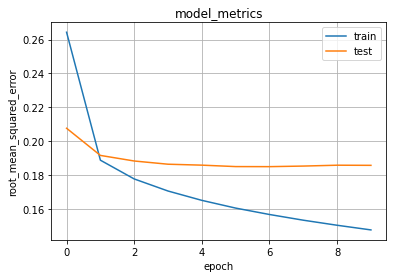

In [58]:
plt.plot(history.history['root_mean_squared_error'])
plt.plot(history.history['val_root_mean_squared_error'])
plt.title('model_metrics')
plt.ylabel('root_mean_squared_error')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.grid(True)
plt.show()

Berdasarkan metriks tersebut menunjukkan bahwa model yang telah dibuat memiliki nilai Root Mean Squared Error (RMSE) sebesar 0.185

## Mendapatkan Rekomendasi

In [59]:
books_df = books
df = pd.read_csv('book-recommendation-dataset/Ratings.csv')
 
# Mengambil sample user
user_id = df['User-ID'].sample(1).iloc[0]
book_read_by_user = df[df['User-ID'] == user_id]
 
# Operator bitwise (~), bisa diketahui di sini https://docs.python.org/3/reference/expressions.html 
book_not_read = books_df[~books_df['ISBN'].isin(book_read_by_user.ISBN.values)]['ISBN']
book_not_read = list(
    set(book_not_read)
    .intersection(set(isbn_to_isbn_encoded.keys()))
)
 
book_not_read = [[isbn_to_isbn_encoded.get(x)] for x in book_not_read]
user_encoder = user_to_user_encoded.get(user_id)
user_book_array = np.hstack(
    ([[user_encoder]] * len(book_not_read), book_not_read)
)

In [60]:
ratings = model.predict(user_book_array).flatten()
 
top_ratings_indices = ratings.argsort()[-10:][::-1]
recommended_book_isbns = [
    isbn_encoded_to_isbn.get(book_not_read[x][0]) for x in top_ratings_indices
]
 
print('Showing recommendations for users: {}'.format(user_id))
print('===' * 9)
print('Books with high ratings from user')
print('----' * 8)
 
top_book_user = (
    book_read_by_user.sort_values(
        by = 'Book-Rating',
        ascending=False
    )
    .head(5)
    .ISBN.values
)
 
book_df_rows = books_df[books_df['ISBN'].isin(top_book_user)]
for row in book_df_rows.itertuples():
    print(row._3, "-", row._2)
 
print('----' * 8)
print('Top 10 book recommendation')
print('----' * 8)
 
recommended_books = books_df[books_df['ISBN'].isin(recommended_book_isbns)]
for row in recommended_books.itertuples():
    print(row._3, "-", row._2)

Showing recommendations for users: 217173
Books with high ratings from user
--------------------------------
Anne Rice - Belinda
Jane Austen - Pride and Prejudice
RAYMOND FEIST - MAGICIAN : MASTER
David McCullough - John Adams
Jeffrey Kacirk - Forgotten English
--------------------------------
Top 10 book recommendation
--------------------------------
J.R.R. TOLKIEN - The Return of the King (The Lord of the Rings, Part 3)
Philip D. Eastman - Go, Dog, Go (I Can Read It All by Myself Beginner Books)
J. K. Rowling - Harry Potter and the Sorcerer's Stone (Book 1)
J. R. R. Tolkien - The Two Towers (The Lord of the Rings, Part 2)
Shel Silverstein - The Giving Tree
Bill Watterson - Calvin and Hobbes
Jodi Picoult - My Sister's Keeper : A Novel (Picoult, Jodi)
Scott Adams - Dilbert: A Book of Postcards
Stephen King - Wolves of the Calla (The Dark Tower, Book 5)
J. K. Rowling - Harry Potter and the Chamber of Secrets Postcard Book


## Penutup
Saat ini model untuk mendapatkan rekomendasi buku telah didapatkan. Dengan model ini dapat diimplementasikan lebih lanjut menjadi aplikasi yang siap digunakan. Namun tentu saja model ini juga masih dapat disempurnakan dengan pengembangan lebih lanjut.